In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split , GridSearchCV
from sklearn.ensemble import RandomForestClassifier , RandomForestRegressor # example model

In [3]:
df = pd.read_csv("/content/give_me_some_credit.csv")
df = df.dropna()
df = df.drop(['Unnamed: 0'], axis=1)
X = df.drop(['SeriousDlqin2yrs'], axis=1)
y = df['SeriousDlqin2yrs']

In [34]:
# Model
model = RandomForestClassifier()


# param_grid = {
#     'n_estimators': [200, 500, 1000],
#     'max_depth': [10, 20, 50],
#     'min_samples_split': [5, 7, 10],
#     'min_samples_leaf': [2, 4, 7],
#     'max_features': ['sqrt'],
#     'random_state': [42],
#     'bootstrap': [True, False],  # Test both bootstrap options
#     'oob_score': [True, False],  # Test OOB score (only effective when bootstrap=True)
#     'criterion': ['gini', 'entropy'],  # Test splitting criteria
#     'class_weight': [None, 'balanced']  # Handle potential class imbalance
# }

# # GridSearchCV
# grid_search = GridSearchCV(
#     estimator=model,
#     param_grid=param_grid,
#     n_jobs=8,
#     scoring='accuracy',
#     cv=5,
#     verbose=1
# )

param_grid = {
    'n_estimators': [200],
    'max_depth': [10],
    'min_samples_split': [5],
    'min_samples_leaf': [7],
    'max_features': ['sqrt'],
    'random_state': [42],
    'criterion': ['gini'],
    'bootstrap': [True],
    'oob_score': [True],
    'criterion': ['gini'],
    'class_weight': [None]  # Handle potential class imbalance
}

# GridSearchCV
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    n_jobs=8,
    scoring='accuracy',
    cv=5,
    verbose=1
)

grid_search.fit(X, y)

print("Best Parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

best_model = grid_search.best_estimator_

if best_model.oob_score:
    print("OOB Score of Best Model:", best_model.oob_score_)

# Best Parameters: {'bootstrap': True, 'class_weight': None, 'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 7, 'min_samples_split': 5, 'n_estimators': 200, 'oob_score': True, 'random_state': 42}
# Best score: 0.9344386361441064

Fitting 5 folds for each of 8 candidates, totalling 40 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
10 fits failed out of a total of 40.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_forest.py", line 448, in fit
    raise ValueError("Out of bag 

Best Parameters: {'bootstrap': True, 'class_weight': None, 'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 7, 'min_samples_split': 5, 'n_estimators': 200, 'oob_score': True, 'random_state': 42}
Best score: 0.9344386361441064
OOB Score of Best Model: 0.9344386333968022


# Gini Importance

In [35]:
# Get feature names, unique counts, and importances
feature_names = X.columns
number_of_unique = X.nunique().to_frame('number unique')
importance = best_model.feature_importances_

# Create importance DataFrame and sort
importance_df = pd.DataFrame({
    'features': feature_names,
    'importance': importance,
    'n_unique': number_of_unique['number unique']
}).sort_values('importance', ascending=True)  # Sort for horizontal bar plot



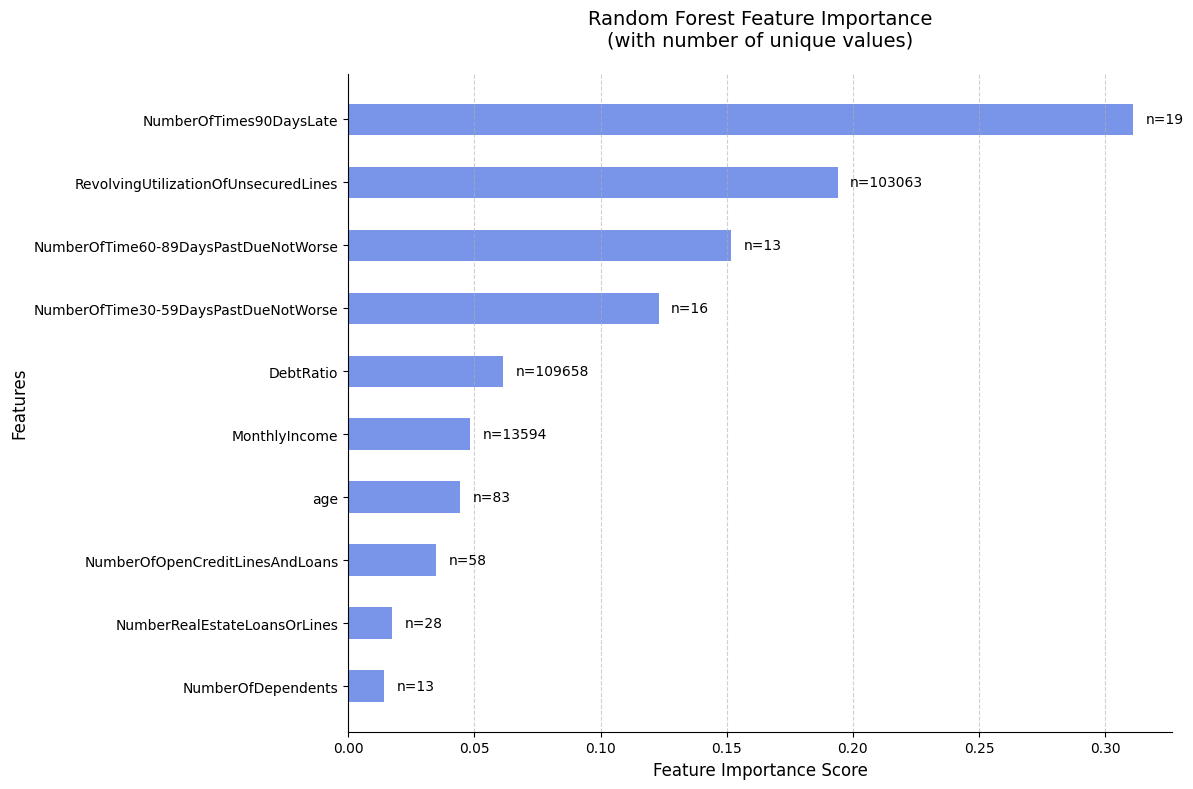

In [36]:
# Create the plot
plt.figure(figsize=(12, 8))
bars = plt.barh(importance_df['features'],
                importance_df['importance'],
                color='royalblue',
                alpha=0.7,
                height=0.5)

# Add value labels on the right of each bar
for i, (importance_val, n_unique) in enumerate(zip(
    importance_df['importance'],
    importance_df['n_unique']
)):
    plt.text(
        importance_val + 0.005,  # X-position: slightly right of bar end
        i,                       # Y-position: aligns with bar center
        f"n={int(n_unique)}",    # Text to display
        va='center',             # Vertical alignment
        ha='left',               # Horizontal alignment
        fontsize=10,
        color='black'
    )

# Customize the plot
plt.xlabel('Feature Importance Score', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.title('Random Forest Feature Importance\n(with number of unique values)',
          fontsize=14, pad=20)
plt.grid(axis='x', linestyle='--', alpha=0.6)

# Remove top and right spines for cleaner look
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

#Permutation Importance

In [38]:
def permutation_importance(X, y, model):
    baseline_score = model.score(X, y)
    X_copy = X.copy()
    feature_names = X.columns
    number_of_unique = X.nunique().to_frame('number unique')
    importance_list = []

    for col in feature_names:
         X[col] = np.random.permutation(X[col].values)
         importance = baseline_score - model.score(X, y)
         importance_list.append(importance)
         X[col] = X_copy[col]

    importance_df = pd.DataFrame({
    'features': feature_names,
    'importance': importance_list,
    'n_unique': number_of_unique['number unique']
     }).sort_values('importance', ascending=True)
    importance_df['importance'] = importance_df['importance']/importance_df['importance'].sum() #expressed as a precentage
    return importance_df


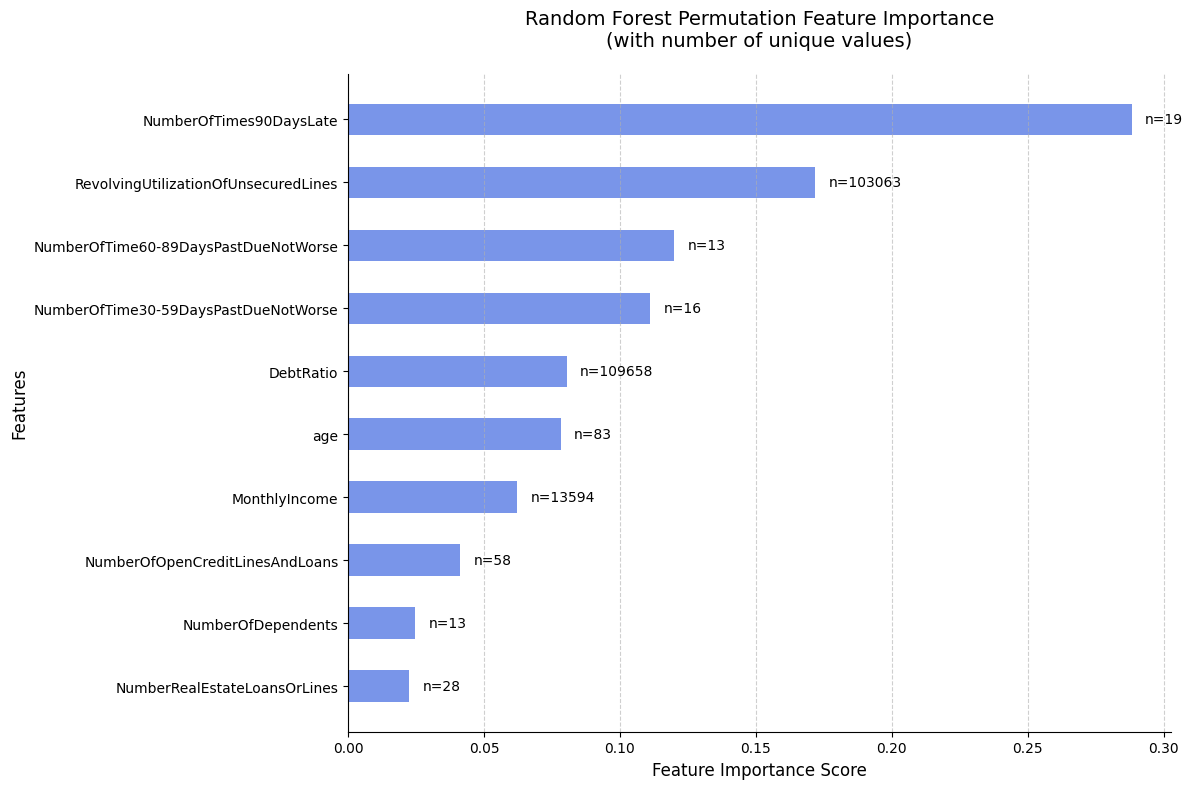

In [39]:
importance_df = permutation_importance(X, y, best_model)

# Create the plot
plt.figure(figsize=(12, 8))
bars = plt.barh(importance_df['features'],
                importance_df['importance'],
                color='royalblue',
                alpha=0.7,
                height=0.5)

# Add value labels on the right of each bar
for i, (importance_val, n_unique) in enumerate(zip(
    importance_df['importance'],
    importance_df['n_unique']
)):
    plt.text(
        importance_val + 0.005,  # X-position: slightly right of bar end
        i,                       # Y-position: aligns with bar center
        f"n={int(n_unique)}",    # Text to display
        va='center',             # Vertical alignment
        ha='left',               # Horizontal alignment
        fontsize=10,
        color='black'
    )

# Customize the plot
plt.xlabel('Feature Importance Score', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.title('Random Forest Permutation Feature Importance\n(with number of unique values)',
          fontsize=14, pad=20)
plt.grid(axis='x', linestyle='--', alpha=0.6)

# Remove top and right spines for cleaner look
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

# Drop-Column Importance

In [46]:
def drop_column_importance(X, y, model):
    baseline_score = model.score(X, y)
    X_copy = X.copy()
    feature_names = X.columns
    number_of_unique = X.nunique().to_frame('number unique')
    importance_list = []

    param_grid = {
        'n_estimators': [200],
        'max_depth': [10],
        'min_samples_split': [5],
        'min_samples_leaf': [7],
        'max_features': ['sqrt'],
        'random_state': [42],
        'criterion': ['gini'],
        'bootstrap': [True],
        'oob_score': [True],
        'criterion': ['gini'],
        'class_weight': [None]  # Handle potential class imbalance
    }

    # GridSearchCV
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        n_jobs=8,
        scoring='accuracy',
        cv=5,
        verbose=1
    )

    for col in feature_names:
        X = X.drop([col], axis=1)
        grid_search.fit(X, y)
        model = grid_search.best_estimator_
        importance = abs(baseline_score - model.score(X, y))
        importance_list.append(importance)
        X[col] = X_copy[col]


    importance_df = pd.DataFrame({
    'features': feature_names,
    'importance': importance_list,
    'n_unique': number_of_unique['number unique']
     }).sort_values('importance', ascending=True)
    importance_df['importance'] = importance_df['importance']/importance_df['importance'].sum() #expressed as a precentage
    return importance_df

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


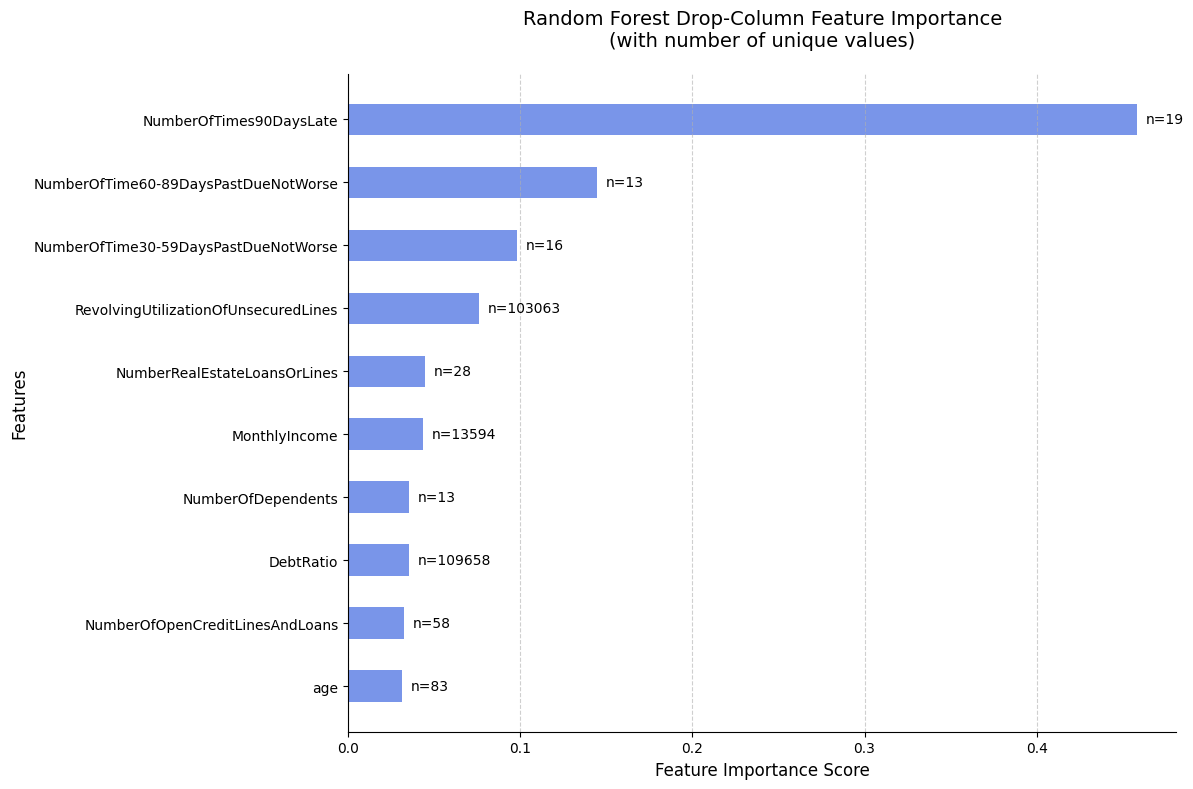

In [47]:
importance_df = drop_column_importance(X, y, best_model)

# Create the plot
plt.figure(figsize=(12, 8))
bars = plt.barh(importance_df['features'],
                importance_df['importance'],
                color='royalblue',
                alpha=0.7,
                height=0.5)

# Add value labels on the right of each bar
for i, (importance_val, n_unique) in enumerate(zip(
    importance_df['importance'],
    importance_df['n_unique']
)):
    plt.text(
        importance_val + 0.005,  # X-position: slightly right of bar end
        i,                       # Y-position: aligns with bar center
        f"n={int(n_unique)}",    # Text to display
        va='center',             # Vertical alignment
        ha='left',               # Horizontal alignment
        fontsize=10,
        color='black'
    )

# Customize the plot
plt.xlabel('Feature Importance Score', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.title('Random Forest Drop-Column Feature Importance\n(with number of unique values)',
          fontsize=14, pad=20)
plt.grid(axis='x', linestyle='--', alpha=0.6)

# Remove top and right spines for cleaner look
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

# Actual Impurity Reduction (AIR) importance

Actual Impurity Reduction (AIR) debiases Gini Importance by accounting for the random impurity reduction caused by high-cardinality features. The theoretical basis involves calculating the impurity reduction for a feature $X_i$ as:

$$ \Delta I(X) = I_{\text{parent}} - \sum_{j} p_j I_j, $$

where $ I_{\text{parent}} $ is the impurity of the parent node, $ p_j $ is the proportion of samples in child node $ j $, and $ I_j $ is the impurity of child node $ j $. For Gini Importance, this reduction is averaged over all trees and nodes where $ X $ is used. However, AIR adjusts this by subtracting the expected impurity reduction from a permuted version of $ X $, denoted $ \Delta I_{\text{perm}}(X) $, which breaks its relationship with the target variable:

$$ \text{AIR}(X) = \Delta I(X) - \mathbb{E}[\Delta I_{\text{perm}}(X)], $$

where $ \mathbb{E}[\Delta I_{\text{perm}}(X)] $ is the expected impurity reduction under random permutation, estimated through multiple permutations. This correction mitigates the bias towards high-cardinality features, as the permuted reduction reflects the artificial gain due to increased split opportunities, providing a more accurate measure of true feature importance.


In [48]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import _tree

def compute_air_importance(model, X, y):
    """
    Compute Actual Impurity Reduction (AIR) importance for a Random Forest model.

    Parameters:
    - model: Trained RandomForestClassifier
    - X: Training data (numpy array or pandas DataFrame)
    - y: Target labels (numpy array or pandas Series)

    Returns:
    - air_importances: Debiased feature importances (numpy array)
    """
    # Ensure X is a numpy array
    X = np.array(X)
    y = np.array(y)
    n_features = X.shape[1]

    # Get the original Gini importance
    original_importances = model.feature_importances_

    # Initialize array to store permuted importances
    permuted_importances = np.zeros(n_features)

    # Compute permuted importance for each feature
    for feature_idx in range(n_features):
        # Create a copy of X and permute the current feature
        X_permuted = X.copy()
        np.random.shuffle(X_permuted[:, feature_idx])

        # Recompute impurity reduction with permuted feature
        feature_importance_permuted = np.zeros(n_features)
        for tree in model.estimators_:
            # Fit the tree on the permuted data
            tree.fit(X_permuted, y)
            # Compute feature importance for this tree
            tree_importance = np.zeros(n_features)
            tree_importance[tree.feature_importances_ != 0] = tree.feature_importances_[tree.feature_importances_ != 0]
            feature_importance_permuted += tree_importance
        # Average over all trees
        permuted_importances[feature_idx] = feature_importance_permuted[feature_idx] / len(model.estimators_)

    # Compute AIR importance (original - permuted)
    air_importances = original_importances - permuted_importances

    # Normalize the importances to sum to 1 (optional, as in scikit-learn)
    if air_importances.sum() != 0:
        air_importances = air_importances / air_importances.sum()

    return air_importances



# Compute AIR importance
air_importances = compute_air_importance(best_model, X, y)

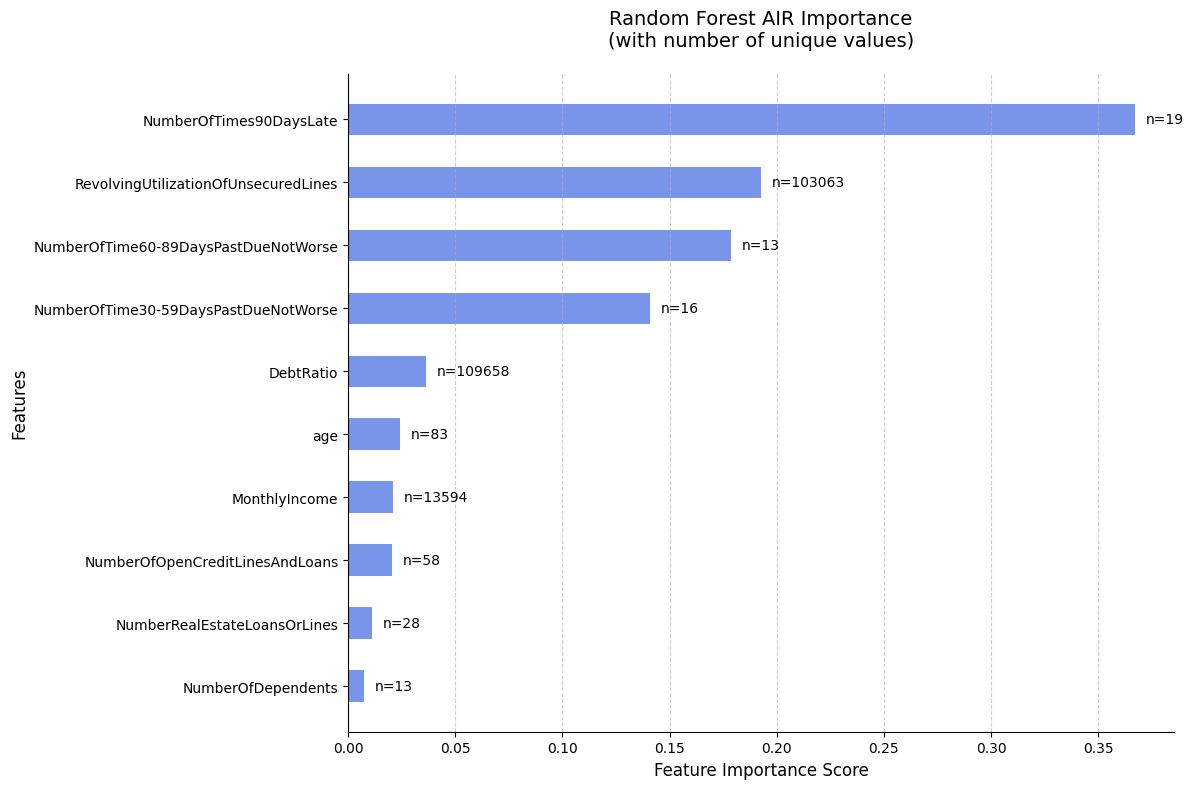

In [49]:
feature_names = X.columns
number_of_unique = X.nunique().to_frame('number unique')

air_importance_df = pd.DataFrame({
    'features': feature_names,
    'importance': air_importances,
    'n_unique': number_of_unique['number unique']
}).sort_values('importance', ascending=True)

# Create the plot
plt.figure(figsize=(12, 8))
bars = plt.barh(air_importance_df['features'],
                air_importance_df['importance'],
                color='royalblue',
                alpha=0.7,
                height=0.5)

# Add value labels on the right of each bar
for i, (importance_val, n_unique) in enumerate(zip(
    air_importance_df['importance'],
    air_importance_df['n_unique']
)):
    plt.text(
        importance_val + 0.005,  # X-position: slightly right of bar end
        i,                       # Y-position: aligns with bar center
        f"n={int(n_unique)}",    # Text to display
        va='center',             # Vertical alignment
        ha='left',               # Horizontal alignment
        fontsize=10,
        color='black'
    )

# Customize the plot
plt.xlabel('Feature Importance Score', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.title('Random Forest AIR Importance\n(with number of unique values)',
          fontsize=14, pad=20)
plt.grid(axis='x', linestyle='--', alpha=0.6)

# Remove top and right spines for cleaner look
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

# SHAP-value

In [50]:
import shap
import numpy as np
from sklearn.ensemble import RandomForestClassifier




# Compute SHAP values
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X)  #X_test

# Calculate mean absolute SHAP values for feature importance
shap_importance = np.abs(shap_values).mean(axis=0)


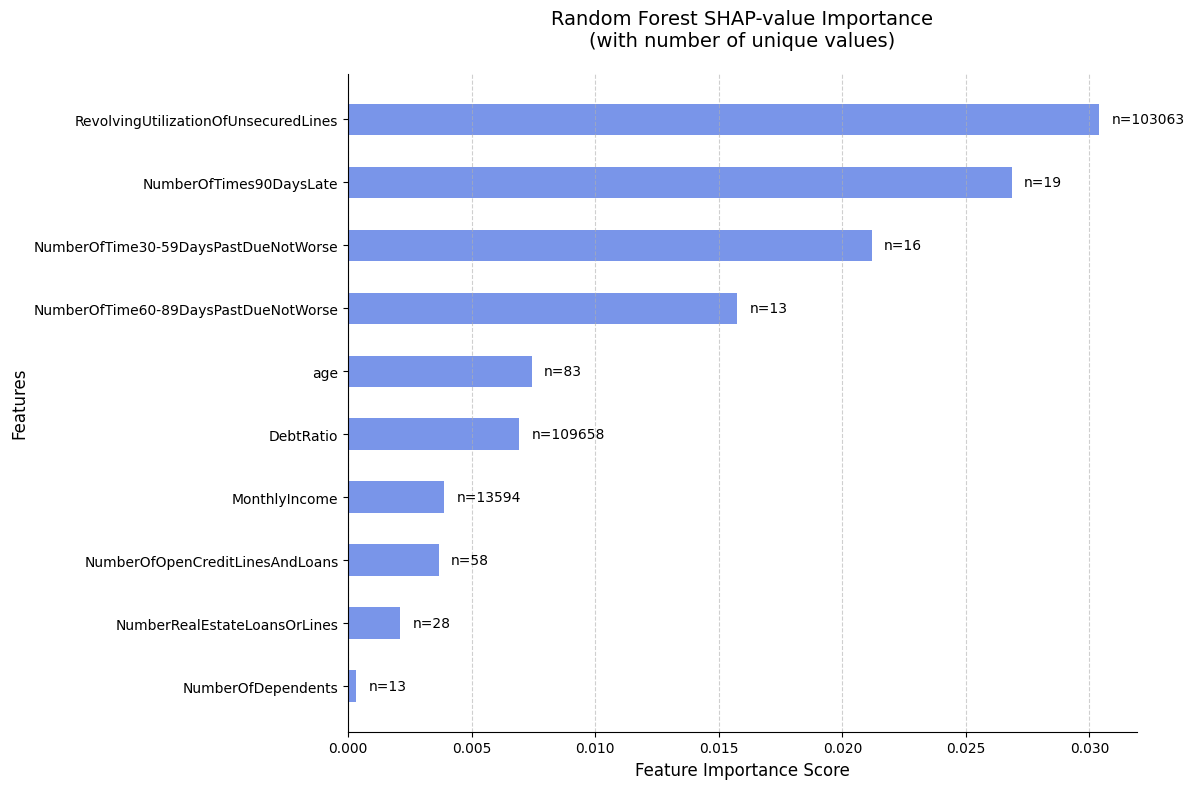

In [32]:
feature_names = X.columns
number_of_unique = X.nunique().to_frame('number unique')

shap_importance_df = pd.DataFrame({
    'features': feature_names,
    'importance': shap_importance[:,0],
    'n_unique': number_of_unique['number unique']
}).sort_values('importance', ascending=True)

# Create the plot
plt.figure(figsize=(12, 8))
bars = plt.barh(shap_importance_df['features'],
                shap_importance_df['importance'],
                color='royalblue',
                alpha=0.7,
                height=0.5)

# Add value labels on the right of each bar
for i, (importance_val, n_unique) in enumerate(zip(
    shap_importance_df['importance'],
    shap_importance_df['n_unique']
)):
    plt.text(
        importance_val + 0.0005,  # X-position: slightly right of bar end
        i,                       # Y-position: aligns with bar center
        f"n={int(n_unique)}",    # Text to display
        va='center',             # Vertical alignment
        ha='left',               # Horizontal alignment
        fontsize=10,
        color='black'
    )

# Customize the plot
plt.xlabel('Feature Importance Score', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.title('Random Forest SHAP-value Importance\n(with number of unique values)',
          fontsize=14, pad=20)
plt.grid(axis='x', linestyle='--', alpha=0.6)

# Remove top and right spines for cleaner look
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.tight_layout()
plt.show()